In [50]:
import numpy as np
import matplotlib.pyplot as plt
from poke.poke_core import Rayfront

import zosapi
zos = zosapi.App()

Exception ignored in: <function PythonStandaloneApplication.__del__ at 0x000002A39D51A440>
Traceback (most recent call last):
  File "c:\Users\Work\anaconda3\envs\pokedev\lib\site-packages\zosapi\zosapi.py", line 85, in __del__
    self.TheApplication.CloseApplication()
System.Runtime.Remoting.RemotingException: Failed to connect to an IPC Port: The system cannot find the file specified.
 

Server stack trace: 
   at System.Runtime.Remoting.Channels.Ipc.IpcPort.Connect(String portName, Boolean secure, TokenImpersonationLevel impersonationLevel, Int32 timeout)
   at System.Runtime.Remoting.Channels.Ipc.ConnectionCache.GetConnection(String portName, Boolean secure, TokenImpersonationLevel level, Int32 timeout)
   at System.Runtime.Remoting.Channels.Ipc.IpcClientTransportSink.ProcessMessage(IMessage msg, ITransportHeaders requestHeaders, Stream requestStream, ITransportHeaders& responseHeaders, Stream& responseStream)
   at System.Runtime.Remoting.Channels.BinaryClientFormatterSink.SyncPr

In [51]:
# simulation params
nrays = 150
wvl = 632.8e-9
D_pup = 25.4e-3

# Gaussian beam size
def wo_from_OF(OF, nrays, Dpup):
    return (Dpup * OF) / (2 * nrays)
wo = wo_from_OF(1.7, nrays, D_pup)
print(f'Using beamlets with waist = {wo * 1e3}mm')


# GBD only cares about first and last surface
s1 = {'surf':1,'coating':1,'mode':'transmit'}
s2 = {'surf':5,'coating':1,'mode':'transmit'}
surflist = [s1, s2]

rf = Rayfront(nrays, wvl, D_pup/2,
              max_fov = 0.01,
              circle=True, # crops rays to a circle defined by D_pup
              waist_pad=0, # extra padding so beamlets are drawn at the edge
              grid='even') # decomposition scheme. 'even' or 'fibonacci'

# Init rayfront and trace rays
rf.as_gaussianbeamlets(wo) 
rf.surfaces = surflist
rf.trace_rayset('C:/Users/work/Desktop/poke/experiments/physics_validation/arago_model.zmx')

Using beamlets with waist = 0.14393333333333333mm
norm fov =  [0. 0.]
base ray shape  (4, 17420)
Ray Failure at surface 5
Ray Failure at surface 5
Ray Failure at surface 5
Ray Failure at surface 5
Ray Failure at surface 5
5 Raysets traced through 2 surfaces


In [52]:
rf.vignetted.shape

(5, 2, 17420)

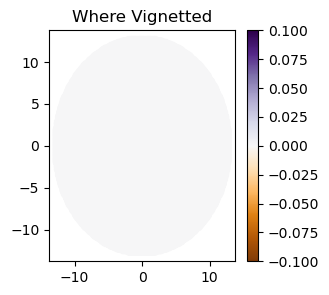

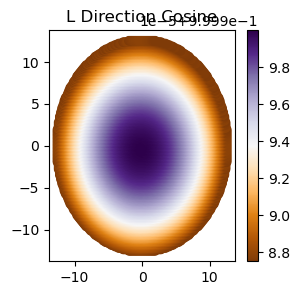

In [53]:
# check the vignetted rays
plt.figure(figsize=[3,3])
plt.title('Where Vignetted')
plt.scatter(rf.xData[0,0], rf.yData[0,0], c=rf.vignetted[0,-1], cmap='PuOr')
plt.colorbar()
plt.show()

# check the vignetted rays
plt.figure(figsize=[3,3])
plt.title('L Direction Cosine')
plt.scatter(rf.xData[0,0], rf.yData[0,0], c=rf.nData[0,-1], cmap='PuOr')
plt.colorbar()
plt.show()

In [54]:
# Now do the GDB simulation

# config detector
npix = 64
d_diam = 5e-4
x = np.linspace(-d_diam/2, d_diam/2, npix)
x,y = np.meshgrid(x,x)

dcoords = np.array([x.ravel(),
                    y.ravel(),
                    np.zeros_like(x.ravel())])

field = rf.beamlet_decomposition_field(dcoords,
                                       memory_avail=4, # a unitless factor to determine available memory
                                       vignette=True, # remove vignetted beamlets
                                       misaligned=True) # flag to use experimental accelerated version

pixels =  4096
rays =  17420
beamlet field at wavelength = 6.328e-07
computeunit =  5806
override nloops =  4
(3, 4096)
(3,)
centroid at =  [-5.12251295e-18 -5.12251295e-18  0.00000000e+00]
centroid offset applied


In [55]:
1.22 * 0.6 * 10

7.32

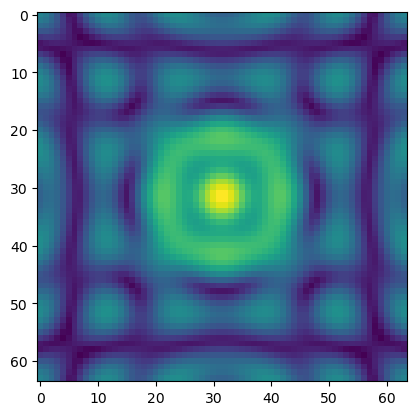

In [56]:
plt.imshow(np.abs(field.reshape([64, 64])))